In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from scipy.stats import chi2_contingency
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

<h1> Data Understanding/ Data Preparation </h1>

In [3]:
df = pd.read_csv("mpg.csv")

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [7]:
for col in df.columns:
    print(f"{col}\n{'-'*30}\n{df[col].unique()}\n")


mpg
------------------------------
[18.  15.  16.  17.  14.  24.  22.  21.  27.  26.  25.  10.  11.   9.
 28.  19.  12.  13.  23.  30.  31.  35.  20.  29.  32.  33.  17.5 15.5
 14.5 22.5 24.5 18.5 29.5 26.5 16.5 31.5 36.  25.5 33.5 20.5 30.5 21.5
 43.1 36.1 32.8 39.4 19.9 19.4 20.2 19.2 25.1 20.6 20.8 18.6 18.1 17.7
 27.5 27.2 30.9 21.1 23.2 23.8 23.9 20.3 21.6 16.2 19.8 22.3 17.6 18.2
 16.9 31.9 34.1 35.7 27.4 25.4 34.2 34.5 31.8 37.3 28.4 28.8 26.8 41.5
 38.1 32.1 37.2 26.4 24.3 19.1 34.3 29.8 31.3 37.  32.2 46.6 27.9 40.8
 44.3 43.4 36.4 44.6 40.9 33.8 32.7 23.7 23.6 32.4 26.6 25.8 23.5 39.1
 39.  35.1 32.3 37.7 34.7 34.4 29.9 33.7 32.9 31.6 28.1 30.7 24.2 22.4
 34.  38.  44. ]

cylinders
------------------------------
[8 4 6 3 5]

displacement
------------------------------
[307.  350.  318.  304.  302.  429.  454.  440.  455.  390.  383.  340.
 400.  113.  198.  199.  200.   97.  110.  107.  104.  121.  360.  140.
  98.  232.  225.  250.  351.  258.  122.  116.   79.   88.   71.  

In [8]:
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce").astype("Float64")
df["horsepower"].isna().sum()

6

There are 6 non-numeric values in the "horsepower" column (represented as "?"), which are converted to NaN when the column is coerced to numeric. Out of 398 total entries, this is a small fraction (~1.5%).

We have several options to handle the missing values:

Drop the rows
Fill with a constant or statistical value (mean/median/mode)
Use predictive imputation (e.g., KNN or regression)
Since:

The column is numeric
We want to retain all rows
The number of missing values is small
→ We choose statistical imputation.

To determine whether to use mean or median, we examine the distribution of the "horsepower" values. If the distribution is skewed, median is preferred; if it's symmetric, the mean may be appropriate.

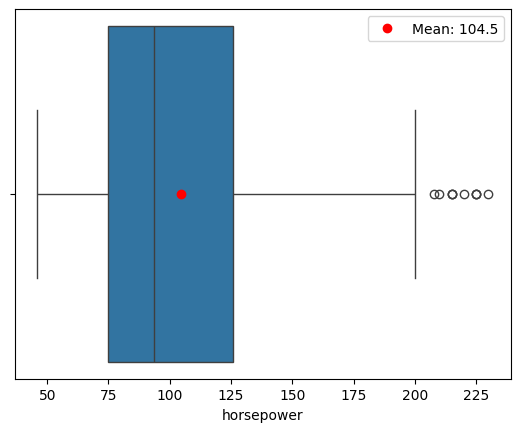

In [9]:
sns.boxplot(x=df["horsepower"])
mean_val = df["horsepower"].mean()
plt.plot(mean_val, 0, 'ro', label=f"Mean: {mean_val:.1f}") 
plt.legend()
plt.show()

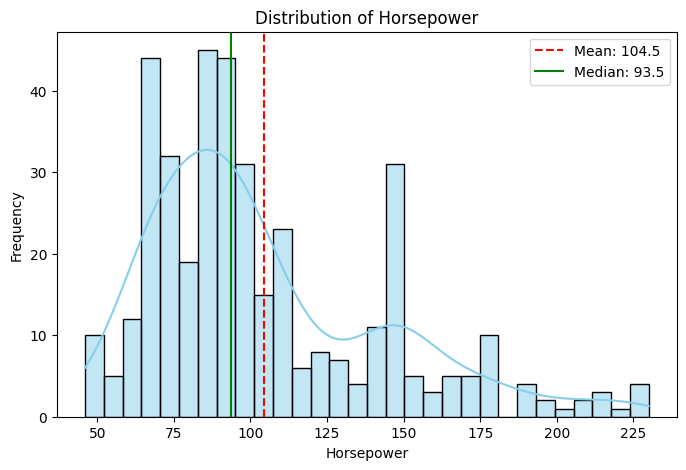

In [10]:
hp_clean = df["horsepower"].dropna()

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(hp_clean, kde=True, bins=30, color="skyblue")

# Add lines for mean and median
mean_val = hp_clean.mean()
median_val = hp_clean.median()

plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.1f}")
plt.axvline(median_val, color='green', linestyle='-', label=f"Median: {median_val:.1f}")

plt.title("Distribution of Horsepower")
plt.xlabel("Horsepower")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The median is smaller than the mean, so horsepower is right-skewed. This means there are many outliers why we will use median imputation. 

In [11]:
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())
df["horsepower"].isna().sum()

0

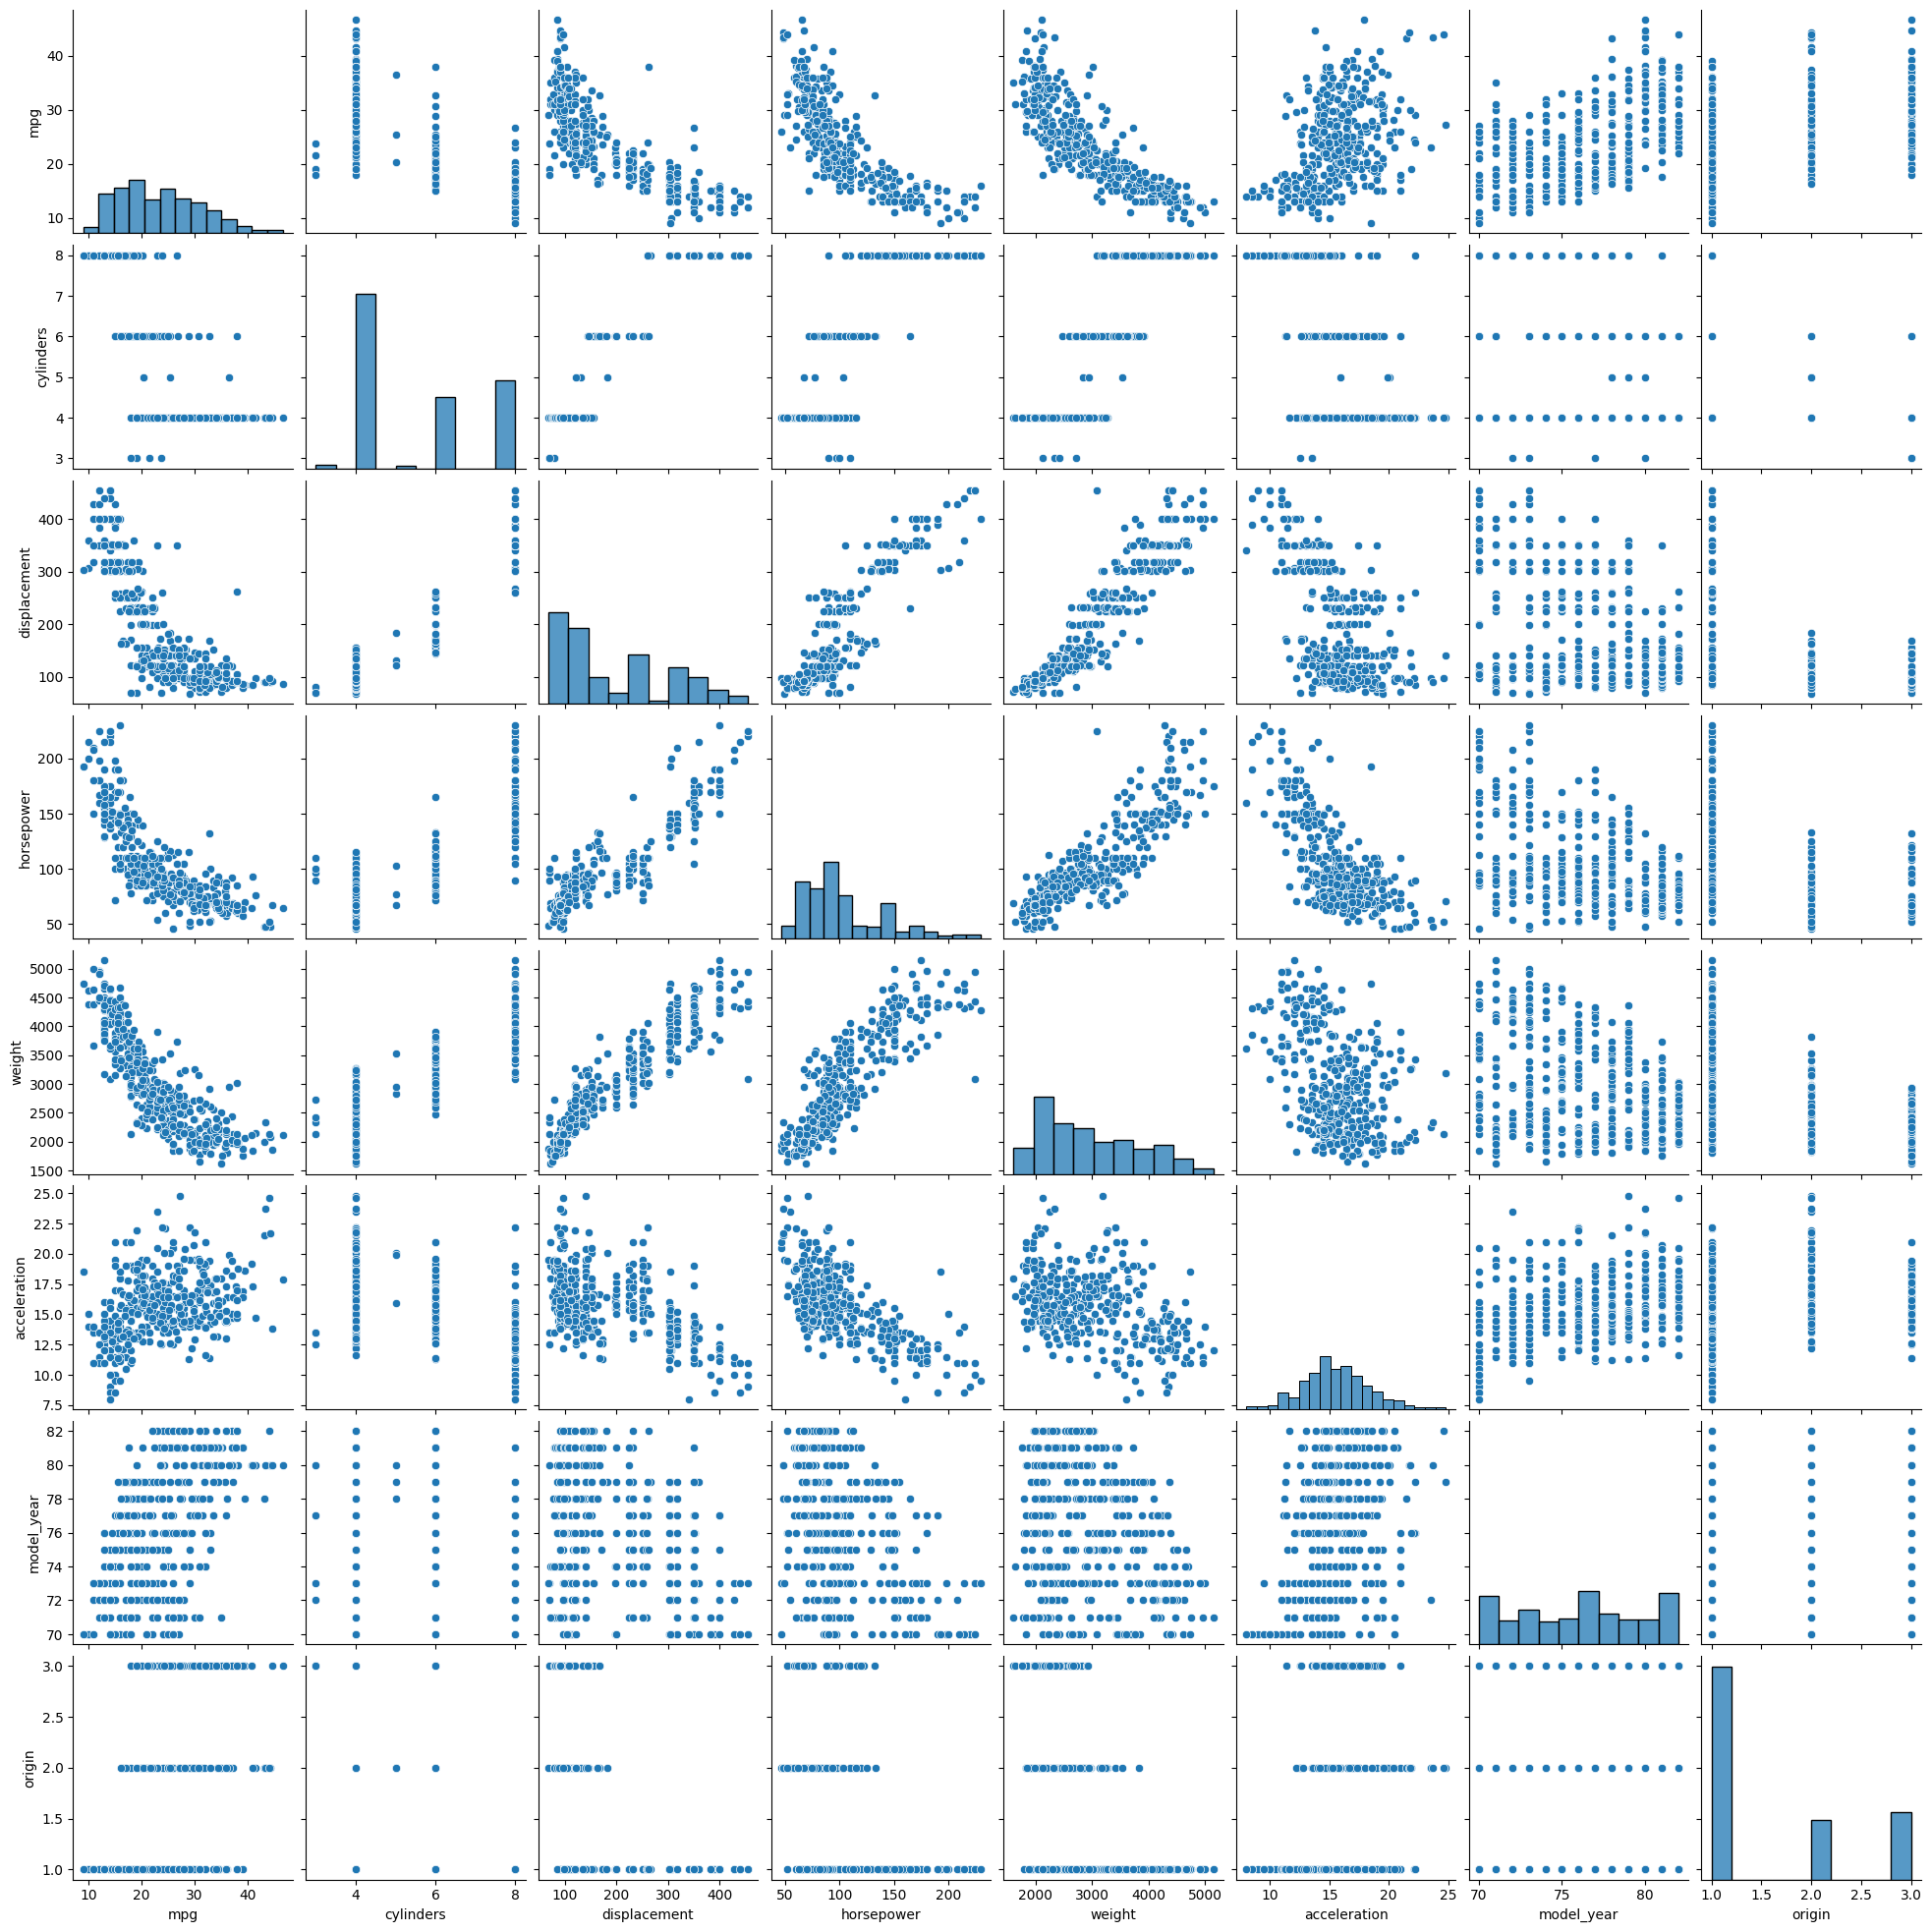

In [12]:
sns.pairplot(df)

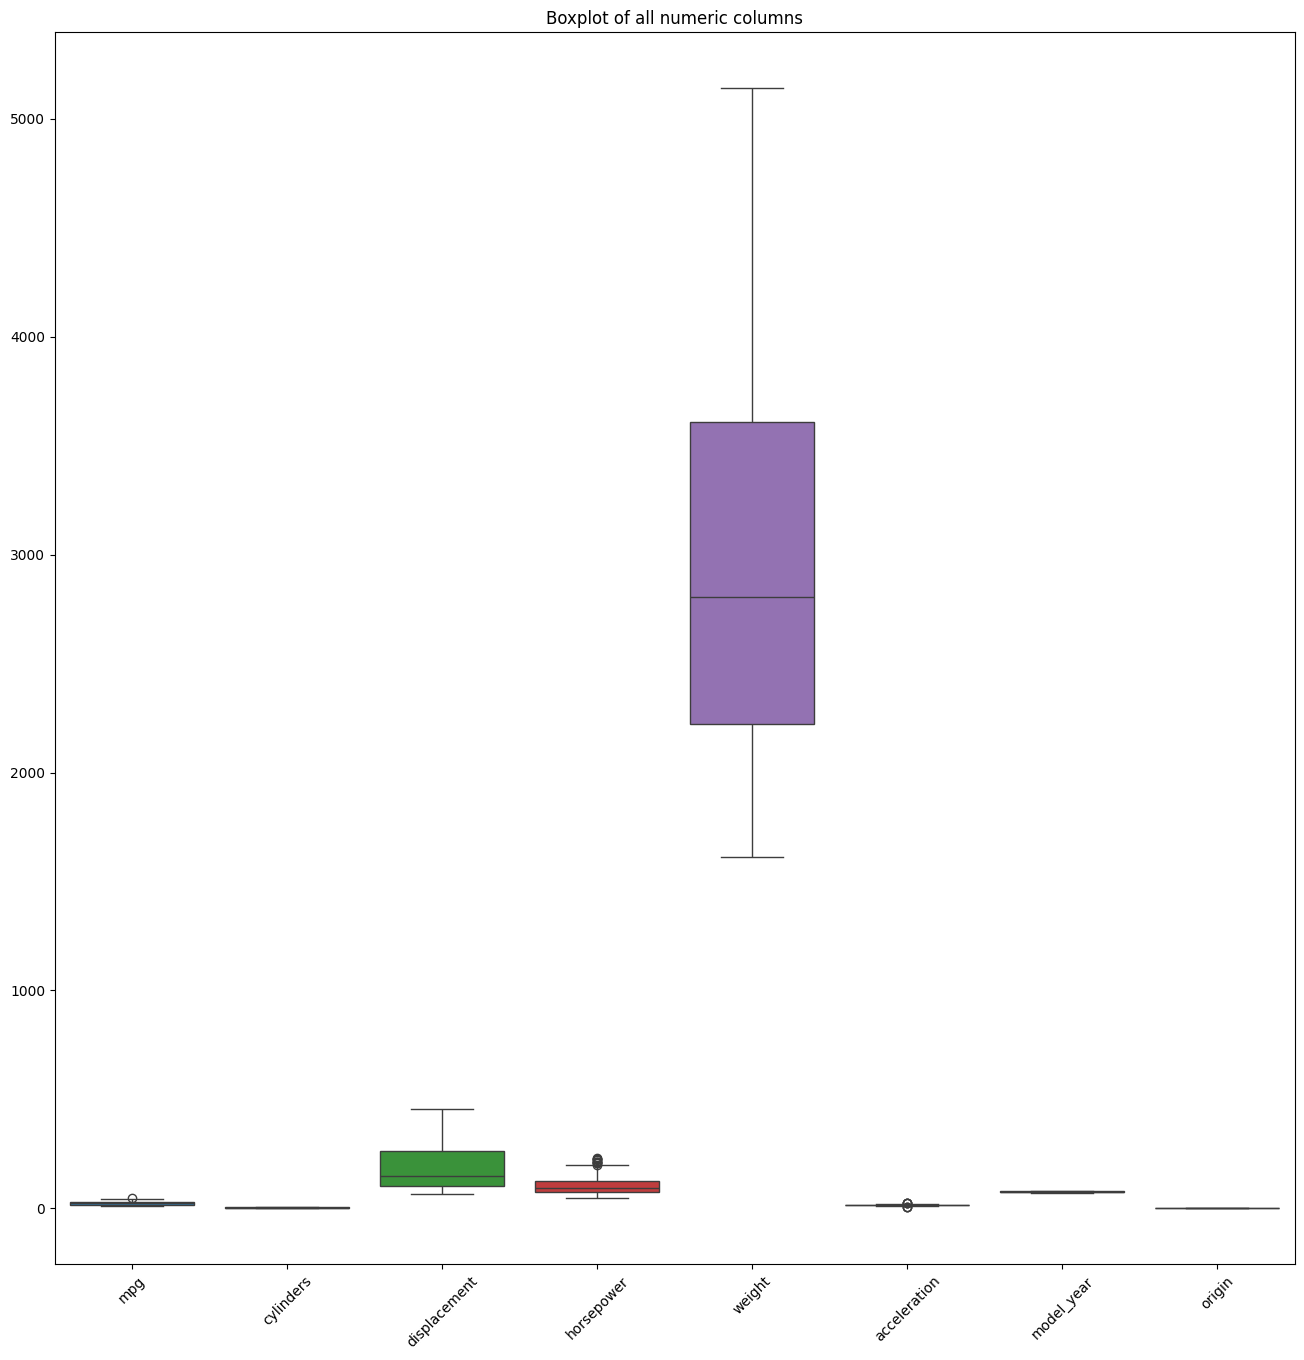

In [13]:
plt.figure(figsize=(16, 16))
sns.boxplot(data=df)
plt.xticks(rotation=45)  
plt.title("Boxplot of all numeric columns")
plt.show()

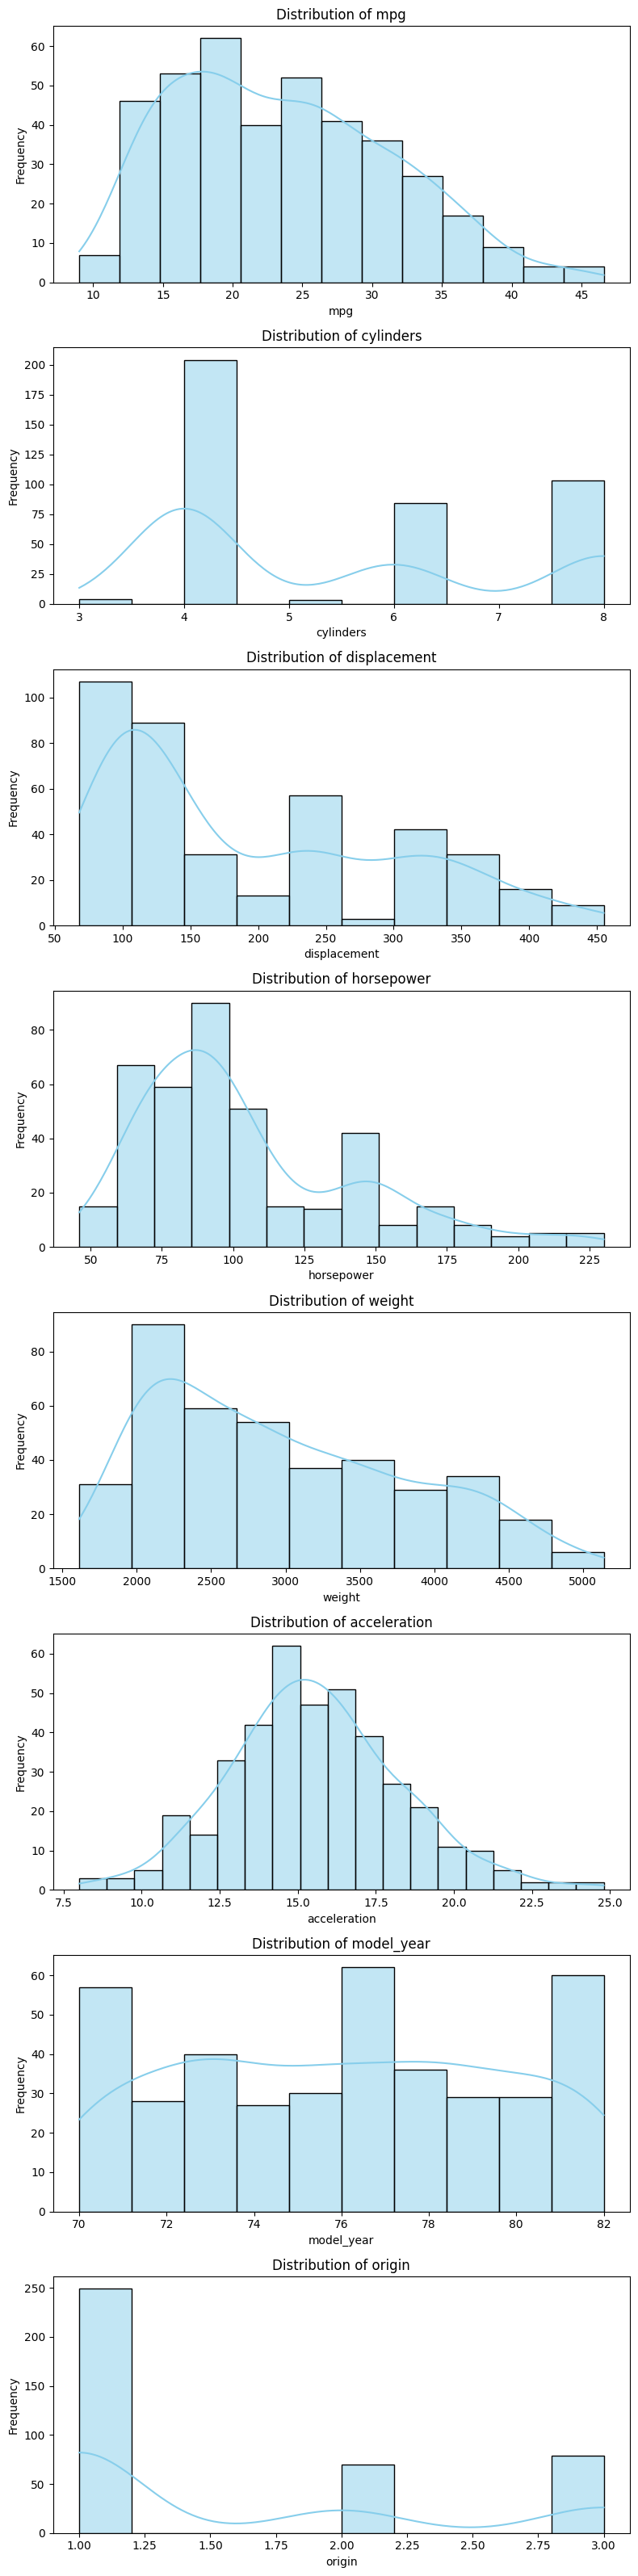

In [14]:
numeric_cols = df.select_dtypes(include='number').columns
num_cols = len(numeric_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(8, 4 * num_cols))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

To avoid multicollinearity, it's important to analyze the correlations between features and select a subset that reduces redundancy. Highly correlated features can distort model coefficients and reduce interpretability. Moreover, PCA can be used to "summarize" features by using linear compbinations of them. 

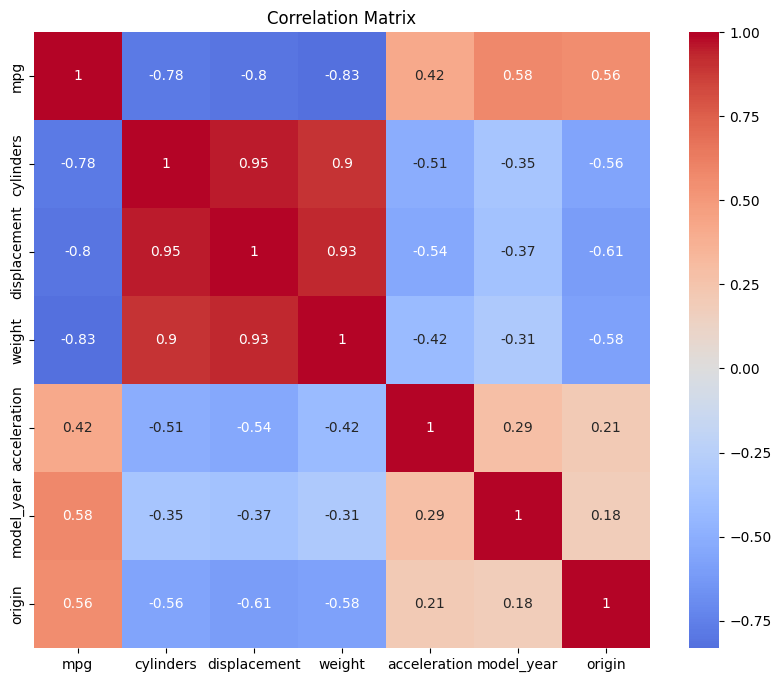

                   mpg  cylinders  displacement    weight  acceleration  \
mpg           1.000000  -0.775396     -0.804203 -0.831741      0.420289   
cylinders    -0.775396   1.000000      0.950721  0.896017     -0.505419   
displacement -0.804203   0.950721      1.000000  0.932824     -0.543684   
weight       -0.831741   0.896017      0.932824  1.000000     -0.417457   
acceleration  0.420289  -0.505419     -0.543684 -0.417457      1.000000   
model_year    0.579267  -0.348746     -0.370164 -0.306564      0.288137   
origin        0.563450  -0.562543     -0.609409 -0.581024      0.205873   

              model_year    origin  
mpg             0.579267  0.563450  
cylinders      -0.348746 -0.562543  
displacement   -0.370164 -0.609409  
weight         -0.306564 -0.581024  
acceleration    0.288137  0.205873  
model_year      1.000000  0.180662  
origin          0.180662  1.000000  


In [15]:
y = df["horsepower"]
X = df.drop(columns="horsepower")
X_numeric = X.select_dtypes(include='number')
X_numeric_corr = X_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(X_numeric_corr, annot=True, cmap="coolwarm", center=0, square=True)
plt.title("Correlation Matrix")
plt.show()

print(X_numeric_corr)

<h2> Target Correlation <h2>

In [16]:
corr = df.select_dtypes(include='number').corr()
print(corr["horsepower"].sort_values(ascending=False))

corr

horsepower      1.000000
displacement    0.895778
weight          0.862442
cylinders       0.841284
model_year     -0.413733
origin         -0.452096
acceleration   -0.686590
mpg            -0.773453
Name: horsepower, dtype: float64


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.000000,-0.775396,-0.804203,-0.773453,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.775396,1.000000,0.950721,0.841284,0.896017,-0.505419,-0.348746,-0.562543
displacement,-0.804203,0.950721,1.000000,0.895778,0.932824,-0.543684,-0.370164,-0.609409
horsepower,-0.773453,0.841284,0.895778,1.000000,0.862442,-0.686590,-0.413733,-0.452096
weight,-0.831741,0.896017,0.932824,0.862442,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.505419,-0.543684,-0.686590,-0.417457,1.000000,0.288137,0.205873
model_year,0.579267,-0.348746,-0.370164,-0.413733,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.562543,-0.609409,-0.452096,-0.581024,0.205873,0.180662,1.000000


<h2> Feature Selection </h2>

We only want to keep features with high variance, because they capture more information than features with low variance

In [17]:
vt = VarianceThreshold(threshold=0.01)  
X_var = vt.fit_transform(X_numeric)

features_var_kept = X_numeric.columns[vt.get_support()]
X_var_df = pd.DataFrame(X_var, columns=features_var_kept)

print("Remaining after variance threshold:", list(features_var_kept))


Remaining after variance threshold: ['mpg', 'cylinders', 'displacement', 'weight', 'acceleration', 'model_year', 'origin']


In [ ]:
# drop highly correlated features to avoid multicolinearity

corr_matrix = X_var_df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X_dedup = X_var_df.drop(columns=to_drop)

print("Dropped due to high correlation:", to_drop)
print("Remaining features:", list(X_dedup.columns))

Dropped due to high correlation: ['displacement', 'weight']
Remaining features: ['mpg', 'cylinders', 'acceleration', 'model_year', 'origin']


In [ ]:
# only keep features that are (highly) correlated with the target because they have a strong predictive power
corr_with_target = df[X_dedup.columns].corrwith(y).abs()

selected = corr_with_target[corr_with_target > 0.3].index.tolist()
X_selected = X_dedup[selected]

print("Selected features based on correlation with target:", selected)


Selected features based on correlation with target: ['mpg', 'cylinders', 'acceleration', 'model_year', 'origin']


In [ ]:
# perform l1 regularization for feature selection 

lasso = Lasso(alpha=0.1)
lasso.fit(X_selected, y)

selected_lasso = X_selected.columns[lasso.coef_ != 0].tolist()
print("Selected features by Lasso:", selected_lasso)

Selected features by Lasso: ['mpg', 'cylinders', 'acceleration', 'model_year', 'origin']


<h1> Modeling </h1>

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  
    Dense(32, activation='relu'),                                          
    Dense(16, activation='relu'),                                         
    Dense(1)                                                                
])


model.compile(
    optimizer='adam',
    loss='mse',             
    metrics=['mae']         
)

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')



history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)


y_pred = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE: {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")

Epoch 1/100


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12956.0664 - mae: 107.3637 - val_loss: 9739.4102 - val_mae: 94.3890
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12830.3398 - mae: 105.6742 - val_loss: 9432.0996 - val_mae: 92.7699
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12447.6543 - mae: 104.6506 - val_loss: 8818.9189 - val_mae: 89.5213
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10695.7529 - mae: 96.7260 - val_loss: 7641.2764 - val_mae: 83.0488
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8740.2109 - mae: 86.7925 - val_loss: 5673.4648 - val_mae: 71.0139
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6180.2466 - mae: 72.4304 - val_loss: 3136.1584 - val_mae: 51.2788
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3043.5276 - mae: 49.1287 - val_loss: 1234.4159 - val_mae: 30.0777
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1095.5168 - mae: 28.0462 - val_loss: 824.5373 - val_mae: 24.3947
Epoch 

Justification of model: 


- Hidden Layer 1:	64 Neurons;	Capture broad patterns across all input features
- Hidden Layer 2:	32 Neorons;	Learn more specific feature interactions
- Hidden Layer 3:	16	Neurons; Compress and distill useful info before output
- Output Layer	1	Predicts a single continuous value (e.g., horsepower)

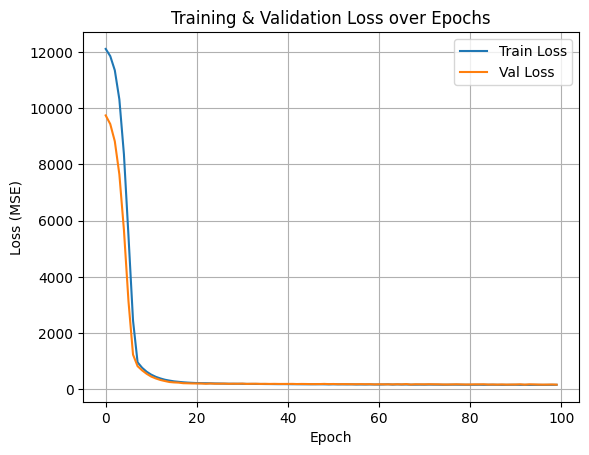

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
